This example examines output from the `blob2d` example included in the `BOUT-dev` repo. \[It was tested with output from the `next` branch at commit 999793fe363e062fd47da20bcd8ff679c85a8b30\].

`blob2d` is a simplified model of an isolated 'blob' or 'filament'. These are coherent, field-aligned structures that are common in the scrape-off layer of tokamaks. `blob2d` represents the evolution only in the plane perpendicular to the magnetic field, with approximate closures describing parallel currents to the sheath and loss of density due to parallel flows. The 'blob' is created by initialising the simulation with a Gaussian density perturbation on a constant background.

You can use it in two ways, either generate the data or download it. Generate by running `blob2d` and then copying its `BOUT.inp` (input file), and `BOUT.dmp.*.nc` (output files) to the directory containing this notebook. Download by running the first Python cell in the 'Setup' section.

Contents:
* Setup
* Load
* Plot
* Animate
* Analyse

Setup
=====

In [1]:
# Download data files if you do not have them already
from pathlib import Path
import urllib.request
for filename in ["BOUT.inp", "BOUT.dmp.0.nc"]:
    if not Path(filename).exists():
        urllib.request.urlretrieve(f"https://zenodo.org/record/4298582/files/{filename}?download=1", filename)

In [2]:
# set up matplotlib
%matplotlib notebook
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (16, 8)

In [3]:
import numpy as np
from xbout import open_boutdataset

Load
====

In [4]:
# open the Dataset

# Pass chunks argument so that dask can parallelise operations over the time dimension
# (by default the chunk size is the size of the arrays in the files being loaded).
# See http://xarray.pydata.org/en/stable/dask.html#chunking-and-performance
#
# Note: a warning from open_boutdataset is expected. For blob2d the z-direction is a
# periodic, binormal direction with lengths normalised to the background hybrid
# gyro-radius rho_s=sqrt(T_e/m_i), rather than the usual toroidal angle. 'dz' is used
# and 'ZMIN' and 'ZMAX' are ignored.
ds = open_boutdataset(chunks={"t": 4})

# Use squeeze() to get rid of the y-dimension, which has length 1 as blob2d does not
# simulate the parallel dimension. Also use drop() to get rid of the remaining
# y-coordinate value, just so that it does not get printed inconveniently.
ds = ds.squeeze()
ds = ds.drop("y")

Read in:
<xbout.BoutDataset>
Contains:
<xarray.Dataset>
Dimensions:   (t: 51, x: 260, y: 1, z: 256)
Coordinates:
  * t         (t) float64 0.0 50.0 100.0 150.0 ... 2.4e+03 2.45e+03 2.5e+03
  * x         (x) int64 0 1 2 3 4 5 6 7 8 ... 252 253 254 255 256 257 258 259
  * y         (y) float64 0.5
  * z         (z) float64 0.0 0.3 0.6 0.9 1.2 1.5 ... 75.3 75.6 75.9 76.2 76.5
Data variables:
    dx        (x, y) float64 dask.array<chunksize=(260, 1), meta=np.ndarray>
    dy        (x, y) float64 dask.array<chunksize=(260, 1), meta=np.ndarray>
    g11       (x, y) float64 dask.array<chunksize=(260, 1), meta=np.ndarray>
    g22       (x, y) float64 dask.array<chunksize=(260, 1), meta=np.ndarray>
    g33       (x, y) float64 dask.array<chunksize=(260, 1), meta=np.ndarray>
    g12       (x, y) float64 dask.array<chunksize=(260, 1), meta=np.ndarray>
    g13       (x, y) float64 dask.array<chunksize=(260, 1), meta=np.ndarray>
    g23       (x, y) float64 dask.array<chunksize=(260, 1), meta=np.n

/home/jomotani/soltransport/pylib/xbout/xbout/load.py:248: UserWarning: No geometry type found, no physical coordinates will be added
  warn("No geometry type found, no physical coordinates will be added")
/home/jomotani/soltransport/pylib/xbout/xbout/geometries.py:151: UserWarning: Size of toroidal domain as calculated from nz*dz (76.8 is not the same as 2pi*(ZMAX - ZMIN) (6.283185307179586): using value from dz
  warn(


In [5]:
# Create a 'coordinate' for the x-dimension from dx.
# dx is a constant for blob2d.
# Ensures we get a sensible aspect ratio in plots.
# Coordinate was already created from dz for the z-dimension, because
# dz is a scalar so it can always be used to create a 1d 'dimension
# coordinate'.
dx = ds["dx"].isel(x=0).values

# Get rid of existing "x" coordinate, which is just the index values.
ds = ds.drop("x")

# Create a new coordinate, which is length in units of rho_s
ds = ds.assign_coords(x=np.arange(ds.sizes["x"])*dx)

Plot
===

<IPython.core.display.Javascript object>


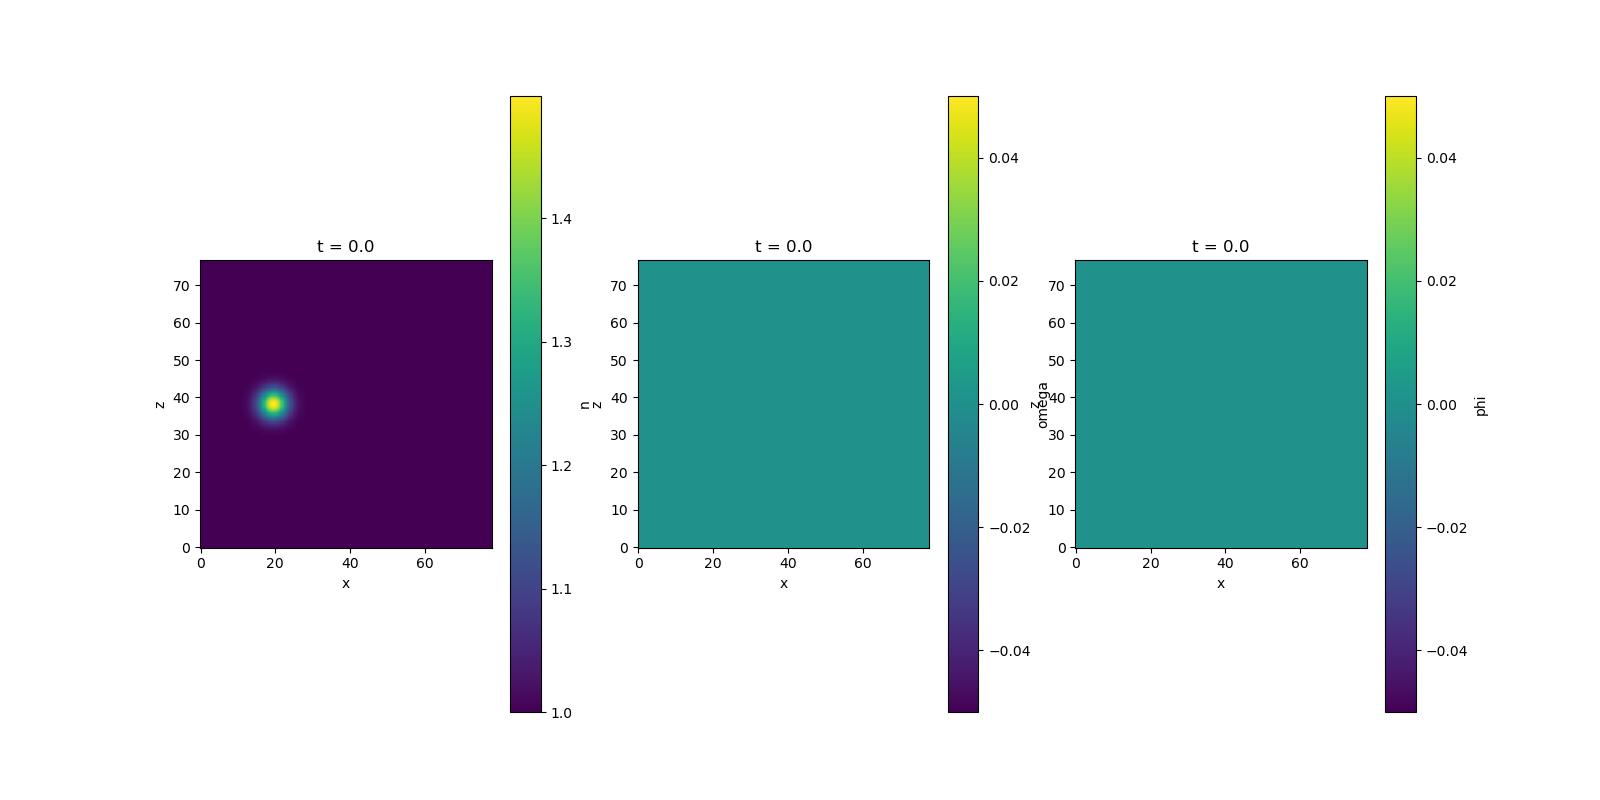

In [6]:
# Initial state
ds_initial = ds.isel(t=0)

# Uses xarray methods to plot simple slices
plt.figure()
ax = plt.subplot(131)
ax.set_aspect("equal")
ds_initial["n"].plot(x="x", y="z")
ax = plt.subplot(132)
ax.set_aspect("equal")
ds_initial["omega"].plot(x="x", y="z")
ax = plt.subplot(133)
ax.set_aspect("equal")
ds_initial["phi"].plot(x="x", y="z")

<IPython.core.display.Javascript object>


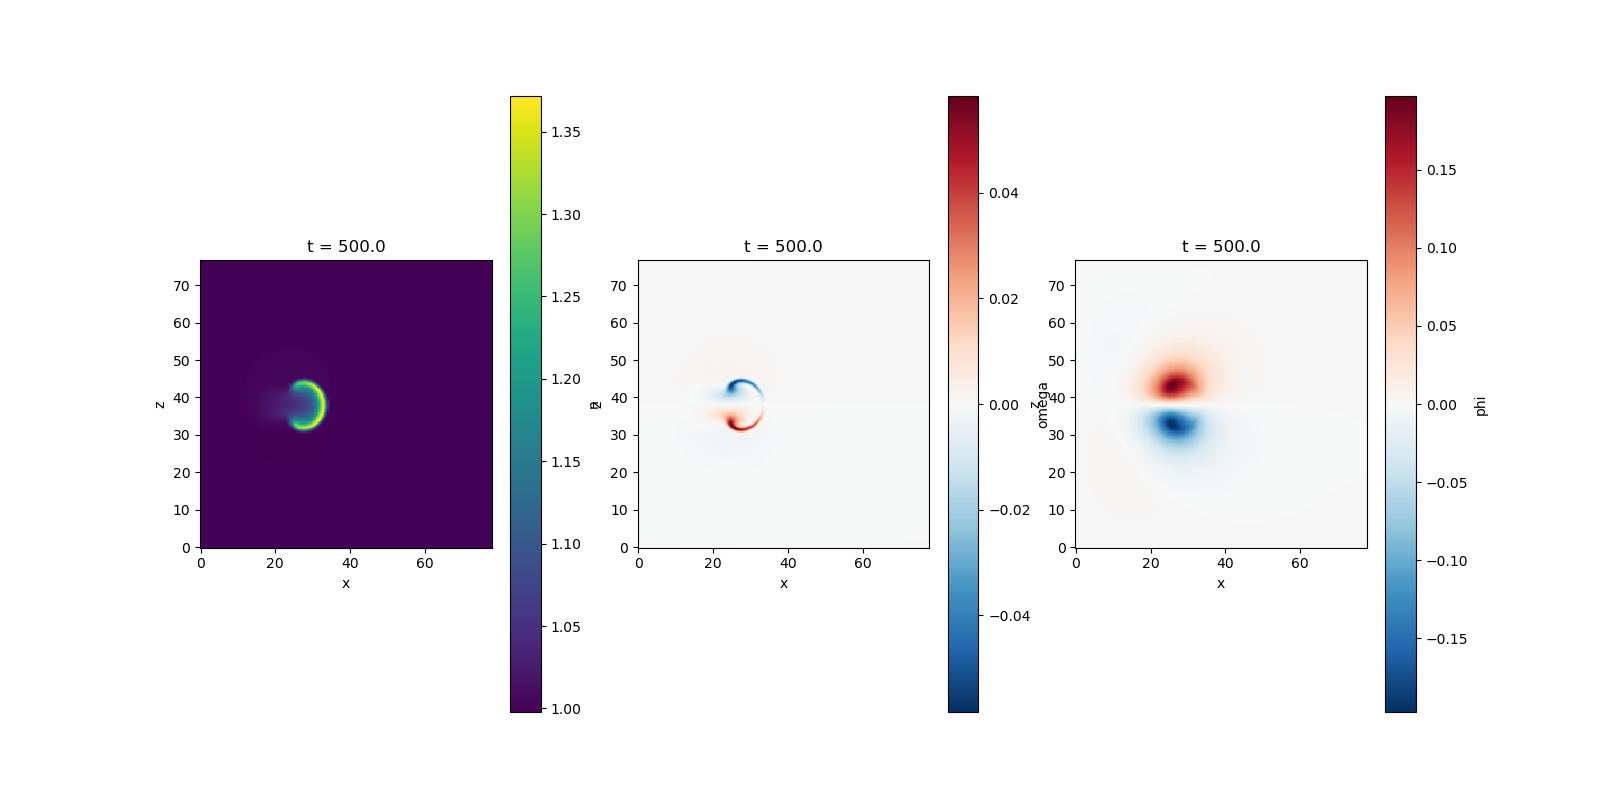

In [7]:
# Plot during the blob evolution
tind = 10

# Uses xarray methods to plot simple slices
plt.figure()
ax = plt.subplot(131)
ax.set_aspect("equal")
ds.isel(t=tind)["n"].plot(x="x", y="z")
ax = plt.subplot(132)
ax.set_aspect("equal")
ds.isel(t=tind)["omega"].plot(x="x", y="z")
ax = plt.subplot(133)
ax.set_aspect("equal")
ds.isel(t=tind)["phi"].plot(x="x", y="z")

<IPython.core.display.Javascript object>


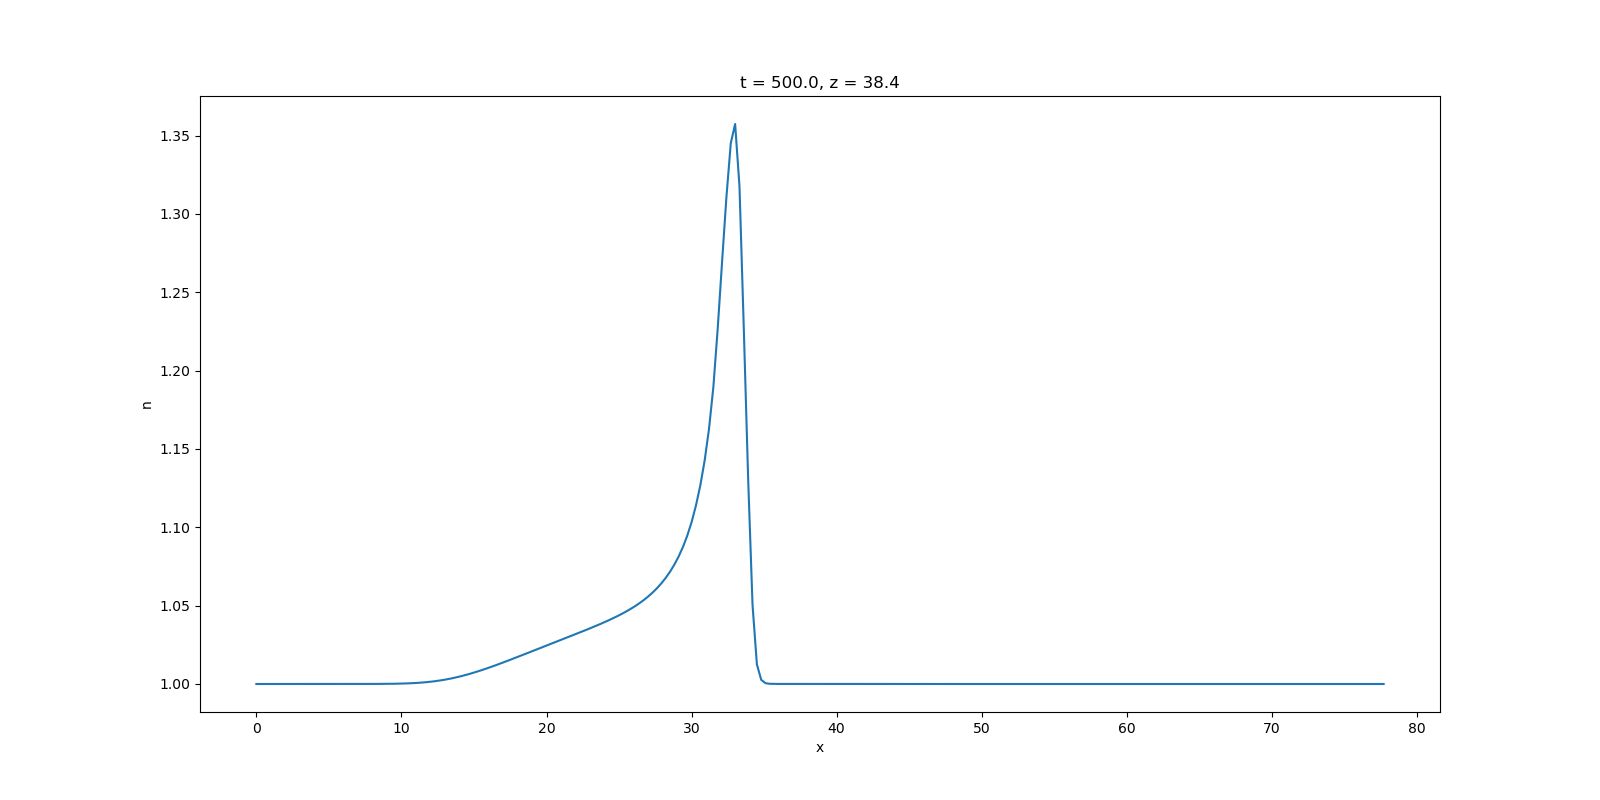

In [8]:
# 1d radial density profile through the blob centre
plt.figure()
ds.isel(t=10, z=128)["n"].plot()

Animate
=======

In [ ]:
# Animate a DataArray
ds["n"].bout.animate2D(aspect="equal")

In [ ]:
# Animate several fields
ds.bout.animate_list(["n", "omega", "phi"], ncols=3, aspect="equal")

In [ ]:
# Can pass DataArray objects (as long as they have the same
# time-axis length), e.g. to combine 1d and 2d plots.
#
# Keyword arguments to animate_list can be passed lists (with as
# many entries as variables being plotted), to set a per-variable
# value.
ds.bout.animate_list(["n", "omega", "phi", ds["n"].isel(z=128)], aspect=["equal", "equal", "equal", "auto"])

Analyse
=======

<IPython.core.display.Javascript object>


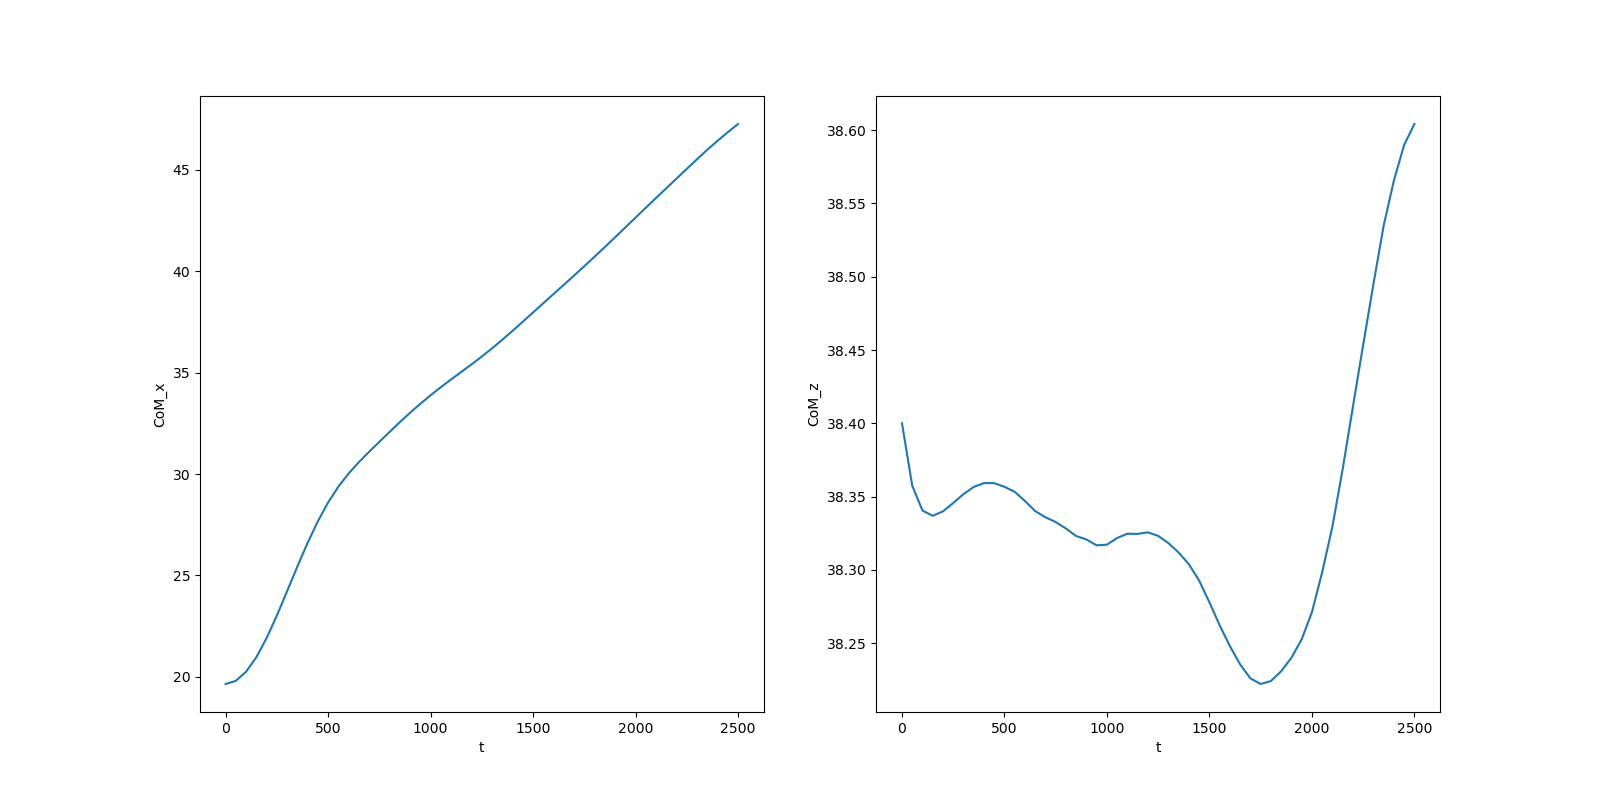

In [9]:
# Find the centre-of mass of the blob
background_density = 1.0
delta_n = ds["n"] - background_density
integrated_density = delta_n.integrate(dim=["x", "z"])
ds["CoM_x"] = (ds["x"]*delta_n).integrate(dim=["x", "z"]) / integrated_density
ds["CoM_z"] = (ds["z"]*delta_n).integrate(dim=["x", "z"]) / integrated_density

plt.figure()
plt.subplot(121)
ds["CoM_x"].plot()
plt.subplot(122)
ds["CoM_z"].plot()

<IPython.core.display.Javascript object>


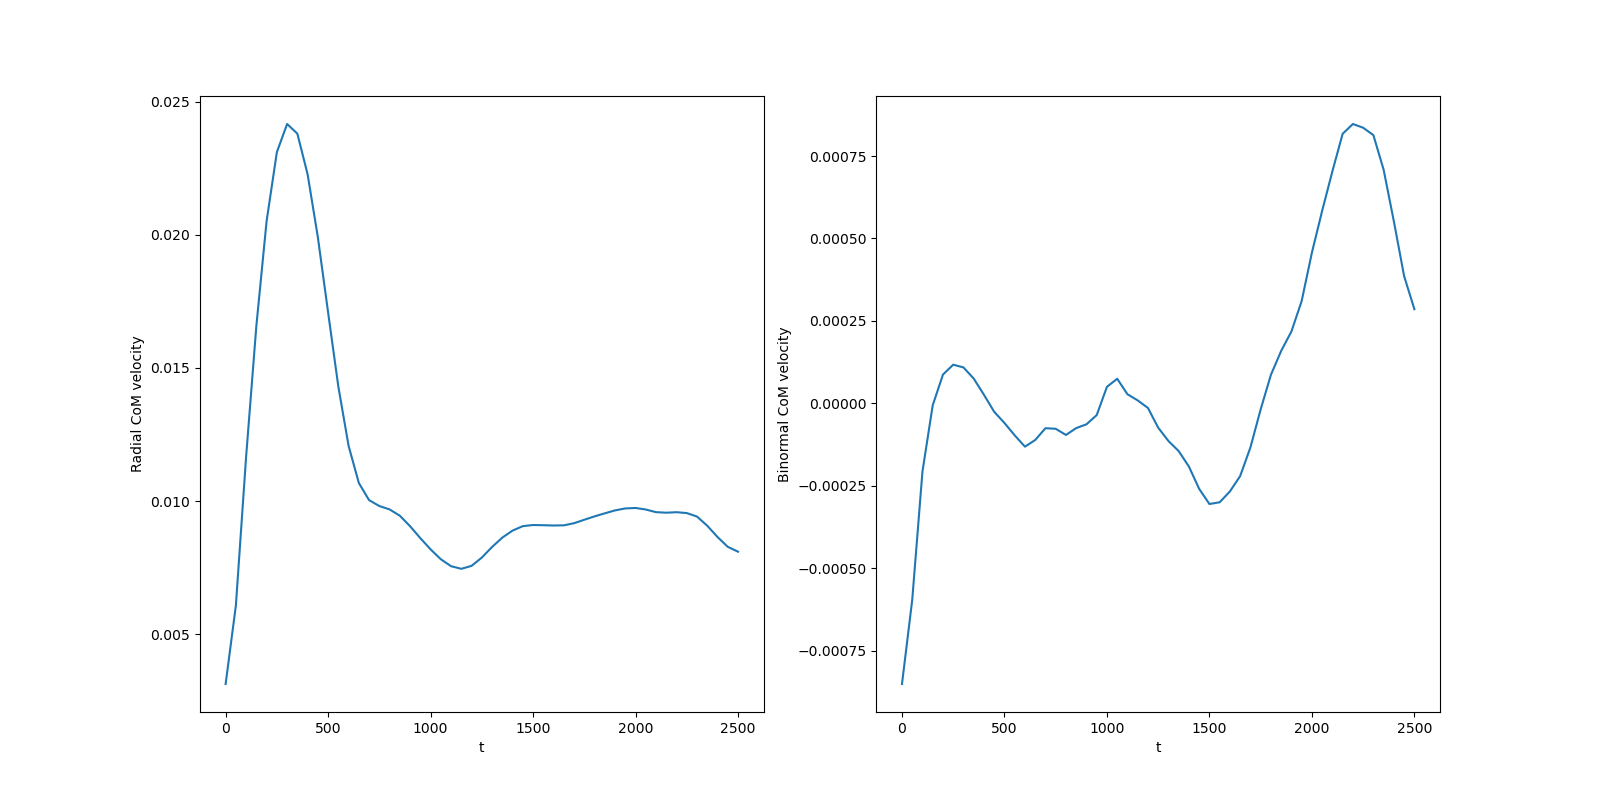

Text(0, 0.5, 'Binormal CoM velocity')

In [10]:
# Find the blob velocity
# Crude method here, using finite difference on the output timestep.
# Would be better to calculate and integrate the ExB velocity.
v_x = ds["CoM_x"].differentiate("t")
v_z = ds["CoM_z"].differentiate("t")

plt.figure()
plt.subplot(121)
v_x.plot()
plt.ylabel("Radial CoM velocity")
plt.subplot(122)
v_z.plot()
plt.ylabel("Binormal CoM velocity")